In [1]:
import pandas as pd
import numpy as np
from typing import List, Tuple
import os
import datetime
import plotly.express as px
import datetime
import random
import matplotlib.pyplot as plt
from copy import deepcopy

## 코드

In [2]:
def visualize_sample(x: np.ndarray, y: np.ndarray, label: list) -> None:
    """
    Visualize it as an html

    Args:
        x (np.ndarray): x
        y (np.ndarray): y
        label (list): label
    """
    fig = px.line(
        pd.DataFrame({'virtual_x': x, 'virtual_y': y}), x='virtual_x', y='virtual_y'
    )
    for l in label:
        fig.add_vline(np.round(l[1], 8), line_dash='dash', annotation_text=l[0])
    fig.update_layout(
        annotations=[
            {**a, **{"y": label[num][2]}}
            for num, a in enumerate(fig.to_dict()["layout"]["annotations"])
        ]
    )

    fig.show()


def get_next_point(
    x_range: list,
    init_value: int,
    state: str,
    max_length: int,
    steady_angle=3,
    beta_allowed_section=0.1,
):

    start, end = x_range
    range_ = end - start

    # valid_angle
    steady_angle = np.min([steady_angle, np.arctan(1 - beta_allowed_section) / np.pi * 180])

    all_x = np.linspace(1 / max_length, (max_length) / max_length, max_length)
    allowed_lamp_angle = beta_allowed_section / (all_x * max_length) + np.tan(
        np.pi / 180 * steady_angle
    )

    if state == 'steady':
        allowed_range = np.tan(np.pi / 180 * steady_angle) * range_
        upper_limit = np.min((init_value + allowed_range, 1))
        lower_limit = np.max((init_value - allowed_range, 0))

    else:
        condition = np.where(np.abs(all_x - range_) <= 1e-8)
        allowed_range = allowed_lamp_angle[condition[0][0]]
        if 'up' in state:
            upper_limit = 1
            lower_limit = np.min((init_value + allowed_range, 1))
        else:
            upper_limit = np.max((init_value - allowed_range, 0))
            lower_limit = 0

        if lower_limit == upper_limit:
            state = 'steady'

    value = np.random.uniform(lower_limit, upper_limit)

    return value, state


def generate_x_y(
    max_length: int,
    split: int,
    steady_angle: int = 3,
    beta_allowed_section: float = 0.1,
    steady_alpha: float = 2.0,
) -> Tuple:
    """
    Create x and y values and choice first PR labels.
    After, PR value and PR label are returned with the get_next_point function.

    Args:
        max_length (int): Max length of data
        split (int): range value

    Returns:
        tuple: x and y and label applied PR logic
    """

    all_point_x = np.linspace(1/max_length, (max_length - 2)/max_length, max_length - 2)
    selected_x = np.random.choice(all_point_x, split - 1, replace=False)
    sorted_selected_x = np.sort(selected_x)

    x = np.concatenate(([0.0], sorted_selected_x, [(max_length - 1) / max_length]))
    y = [np.random.uniform()]

    state_list = ['up', 'down', 'steady']

    state = []
    real_state_list = []
    for split_length in np.diff(x):
        steady_prob = np.random.uniform()

        # steady_criteria = split_length
        steady_criteria = 1 / (1 + np.exp(-np.log(split_length / (1 / split)) * steady_alpha))

        if steady_prob <= steady_criteria:
            state.append('steady')
        else:
            state.append(np.random.choice([st for st in state_list if st != 'steady']))

    for num, xx in enumerate(x[:-1]):
        yy, real_state = get_next_point(
            x[num : num + 2],
            y[num],
            state[num],
            max_length,
            steady_angle,
            beta_allowed_section,
        )
        y.append(yy)
        real_state_list.append(real_state)

    x = np.array(x)
    y = np.array(y)

    return x, y, real_state_list


def get_label_from_state(x: np.ndarray, real_state: list) -> list:
    """
    Grouped in same section.

    Args:
        x (np.ndarray): PR x values
        real_state (list): PR labels

    Returns:
        list: Grouped PR labels
    """
    init = real_state[0]
    start = 0.0
    label = []
    for num, state in enumerate(real_state):
        if state != init:
            end = x[num]
            label.append([init, start, end])
            start = x[num]
            init = state
    label.append([init, start, 1.0])
    return label


def interpolate_x_y(x: np.ndarray, y: np.ndarray, max_length: int, noise_std: float) -> Tuple:
    """
    Interpolate x and y

    Args:
        x (np.ndarray): _description_
        y (np.ndarray): _description_
        max_length (int): Max length of data

    Returns:
        Tuple:
            'real' : Expressed detail of range more continuously
    """
    x_real = np.linspace(0, (max_length - 1) / max_length, max_length)

    y_real = []
    for num, yy in enumerate(y[:-1]):
        range_ = int(np.round((x[num + 1] - x[num]) * max_length, 0))
        y_real.append(np.linspace(y[num], y[num + 1], range_ + 1)[:-1])
    y_real.append(np.array([y[-1]]))
    y_real = np.concatenate(y_real) + np.random.normal(0, noise_std, max_length)

    # y_real = (y_real - np.min(y_real)) / (np.max(y_real) - np.min(y_real))

    return x_real, y_real


def generate_wrapper(
    max_length: int,
    split: int,
    noise_std: float,
    steady_angle: int = 3,
    beta_allowed_section: float = 0.1,
    steady_alpha: float = 2.0,
) -> Tuple:
    """
    Generate PR wrapper

    Args:
        max_length (int): Max length of data
        split (int): range value

    Returns:
        Tuple:
            'real' : Expressed detail of range more continuously
            label : label
    """

    x, y, real_state_list = generate_x_y(
        max_length, split, steady_angle, beta_allowed_section, steady_alpha
    )
    label = get_label_from_state(x, real_state_list)

    x_real, y_real = interpolate_x_y(x, y, max_length, noise_std)
    return x_real, y_real, label


def generate_sample(
    max_length: int,
    max_split: int,
    sample_num: int,
    noise_std: float = 0.001,
    steady_angle: int = 3,
    beta_allowed_section: float = 0.1,
    steady_alpha: float = 2.0,
):
    """
    Generate data and apply PR

    Args:
        max_length (int): Max length of data
        max_split (int): Generate new elements of data from 3 to max_split
        sample_num (int): Length of total data
        noise_mean (int, optional): Defaults to 0.
        noise_std (float, optional): Defaults to 0.01.

    Returns:
        _type_: list

    """
    min_split_num = 3 if 3 < max_split else max_split
    split_num = np.random.choice(
        range(min_split_num, max_split + 1), sample_num, replace=True
    )
    return list(
        map(
            lambda split: generate_wrapper(
                max_length, split, noise_std, steady_angle, beta_allowed_section, steady_alpha
            ),
            split_num,
        )
    )

In [3]:
def get_row_size(
    n_cols: int,
    time_col: str,
    key_cols: List[str],
    class_col: str,
):
    temp_float = 0.0
    temp_object = "temp"
    
    # make one row data frame
    one_row_dict = {}
    one_row_dict.update({time_col: [temp_object]})
    one_row_dict.update({key_col: [temp_object] for key_col in key_cols})
    one_row_dict.update({class_col: [temp_object]})
    one_row_dict.update({f"column_{i}": [temp_object] for i in range(n_cols)})
    one_row_df = pd.DataFrame(one_row_dict)
    
    # caculate one row data frame's file size in csv
    temp_path = "./temp_row_files.csv"
    one_row_df.to_csv(temp_path, header=None)
    file_size = os.stat(temp_path).st_size / (1024 * 1024)
    os.remove(temp_path)
    
    return file_size

In [4]:
def random_datetime():
    # Get current real-time year and month
    current_time = datetime.datetime.now()
    year = current_time.year
    month = current_time.month

    # Randomly select day, hour, minute, and second
    day = random.randint(1, 28)  # Assume all months have 28 days for simplicity
    hour = random.randint(0, 23)
    minute = random.randint(0, 59)
    second = random.randint(0, 59)

    # Create a random datetime object
    random_dt = datetime.datetime(year, month, day, hour, minute, second)

    return random_dt.strftime('%Y-%m-%d %H:%M:%S')

In [5]:
def generate_timestamp_list(length, interval_seconds=1):
    start_time = pd.to_datetime(random_datetime())
    end_time = start_time + pd.DateOffset(seconds=length * interval_seconds - 1)
    timestamps = pd.date_range(start=start_time, end=end_time, freq=str(interval_seconds) + 'S')
    return timestamps.to_list()

In [6]:
def get_sample_df(
    n_sample_rows: int,
    n_cols: int,
    time_col: str,
    key_cols: List[str],
    class_col: str,
    label: int,
    sample_idx: int,
    sample_value_list: List[List[float]]
):
    sample_dict = {}
    sample_dict.update({time_col: generate_timestamp_list(n_sample_rows)})
    for key_idx, key_col in enumerate(key_cols):
        sample_dict.update({key_col: [f"sample_{sample_idx}_{key_idx}"]*n_sample_rows})
    sample_dict.update({class_col: [label]*n_sample_rows})
    sample_dict.update({f"column_{i}": sample_value_list[i] for i in range(n_cols)})
    sample_df = pd.DataFrame(sample_dict)
    return sample_df

In [7]:
def get_label_list(label_ratio, n_samples):
    label_arr = np.ones(n_samples).astype(int)
    n_normal = int(n_samples*label_ratio)
    label_arr[:n_normal] = 0
    np.random.shuffle(label_arr)
    label_list = list(label_arr)
    return label_list

In [115]:
from copy import deepcopy


def generate_pr_sample(
    file_size: float,
    n_cols: int,
    n_samples: int,
    time_col: str,
    key_cols: List[str],
    class_col: str,
    label_ratio: float=0.5,
    save=False,
    save_path: str=None,
    print_description=True
):

    row_size = get_row_size(n_cols, time_col, key_cols, class_col)
    n_rows = int(np.round(file_size/row_size))
    n_sample_rows = int(np.round(n_rows/n_samples))
    n_max_seg = 5
    
    label_list = get_label_list(label_ratio, n_samples)
    sensor_info_list = generate_sample(n_sample_rows, n_max_seg, n_cols)
    abnormal_seg_idx_list = [random.randint(0, len(label_info)-1) for _, _, label_info in sensor_info_list]
    sample_df_list = []
    for sample_idx in range(n_samples):
        sensor_value_list = []
        sample_label = label_list[sample_idx]
        if sample_label == 1:
            # abnormal wafer mutation
            for sensor_idx, sensor_info in enumerate(sensor_info_list):
                seg_idx = abnormal_seg_idx_list[sensor_idx]
                _, y, label_info = sensor_info
                abnormal_sensor_value = y.copy()
                start_idx = int(label_info[seg_idx][1]*n_sample_rows)
                end_idx = int(label_info[seg_idx][2]*n_sample_rows)
                # offset = np.random.uniform(low=np.min(abnormal_sensor_value), high=np.max(abnormal_sensor_value), size=1) / 20  # abnormal 웨이퍼의 경우 특정 segment를 최대 5 %까지 증가 시킴
                offset = np.random.uniform(low=np.min(abnormal_sensor_value), high=np.max(abnormal_sensor_value), size=abnormal_sensor_value[start_idx:end_idx].shape) / 20  # abnormal 웨이퍼의 경우 특정 segment를 최대 5 %까지 증가 시킴
                abnormal_sensor_value[start_idx:end_idx] = abnormal_sensor_value[start_idx:end_idx] + offset
                sensor_value_list.append(abnormal_sensor_value)
        else:
            sensor_value_list = [y for _, y, _ in sensor_info_list]
        
        # 전체 노이즈 추가
        noise_sensor_value_list = []
        for s_value in sensor_value_list:
            noise = np.random.uniform(low=np.min(s_value), high=np.max(s_value), size=s_value.shape) / 5  # 전체 웨이퍼를 최대 20 %까지 증가 시킴
            noise_sensor_value_list.append(s_value + noise)
        
        sample_df_list.append(get_sample_df(n_sample_rows, n_cols, time_col, key_cols, class_col, sample_label, sample_idx, noise_sensor_value_list))
    concat_df = pd.concat(sample_df_list).reset_index(drop=True)
    
    concat_df.drop_duplicates(inplace=True)
    
    if save:
        if save_path == None:
            current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H%M%S")
            save_path = f"sample_{current_time}.csv"
        concat_df.to_csv(save_path, index=False)
        
    if print_description:
        print(f"✓ File size : {concat_df.memory_usage().sum()/1024/1024:.4f} MiB")
        print(f"✓ Data shape : {concat_df.shape}")
        print(f"✓ Sample length : {np.mean([g.shape[0] for _, g in concat_df.groupby(key_cols)]):.1f}")
        print(f"✓ Normal/Abnormal label : {len([g.shape[0] for _, g in concat_df.groupby(key_cols) if g[class_col].iloc[0] == 0])} / {len([g.shape[0] for _, g in concat_df.groupby(key_cols) if g[class_col].iloc[0] == 1])}")
    
    return concat_df

## 실행

In [116]:
file_size = 1   # 파일 크기 (MiB)
n_cols = 2   # 센서의 개수 
n_samples = 100   # 샘플의 개수 
time_col = "time"
key_cols = ["lotid", "recipe", "wafer_id"]
class_col = "leak"
label_ratio = 0.8   # 전체 샘플 중 normal label을 갖는 샘플의 비율

In [117]:
result_df = generate_pr_sample(
    file_size,
    n_cols,
    n_samples,
    time_col,
    key_cols,
    class_col,
    label_ratio,
    save=True,
    print_description=True
)

✓ File size : 1.7273 MiB
✓ Data shape : (28300, 7)
✓ Sample length : 283.0
✓ Normal/Abnormal label : 80 / 20


In [118]:
result_df

,time,lotid,recipe,wafer_id,leak,column_0,column_1
0,2023-07-06 00:47:35,sample_0_0,sample_0_1,sample_0_2,0,1.020259,0.540103
1,2023-07-06 00:47:36,sample_0_0,sample_0_1,sample_0_2,0,1.037980,0.645878
2,2023-07-06 00:47:37,sample_0_0,sample_0_1,sample_0_2,0,1.047886,0.617327
3,2023-07-06 00:47:38,sample_0_0,sample_0_1,sample_0_2,0,1.135864,0.625560
4,2023-07-06 00:47:39,sample_0_0,sample_0_1,sample_0_2,0,1.069495,0.669593
...,...,...,...,...,...,...,...
28295,2023-07-15 09:56:47,sample_99_0,sample_99_1,sample_99_2,0,0.235150,1.071053
28296,2023-07-15 09:56:48,sample_99_0,sample_99_1,sample_99_2,0,0.132406,1.045566
28297,2023-07-15 09:56:49,sample_99_0,sample_99_1,sample_99_2,0,0.198883,1.089170
28298,2023-07-15 09:56:50,sample_99_0,sample_99_1,sample_99_2,0,0.124881,1.054386


In [119]:
normal_sample_list = [
    sample_df 
    for sample_key, sample_df in result_df.groupby(key_cols) 
    if int(sample_df[class_col].iloc[0]) == 0
]
abnormal_sample_list = [
    sample_df 
    for sample_key, sample_df in result_df.groupby(key_cols)
    if int(sample_df[class_col].iloc[0]) == 1
]

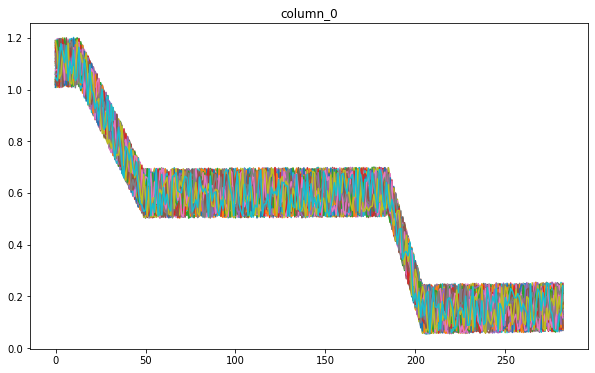

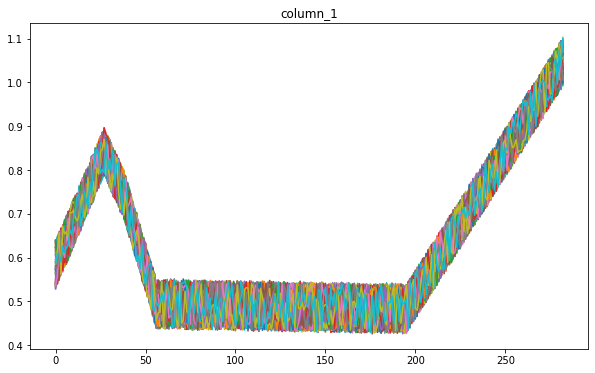

In [120]:
for sensor_name in normal_sample_list[0].columns:
    if sensor_name in [time_col, class_col] + key_cols:
        continue
    plt.figure(figsize=(10,6))
    plt.title(sensor_name)
    for sample in normal_sample_list:
        sample[sensor_name].reset_index(drop=True).plot()

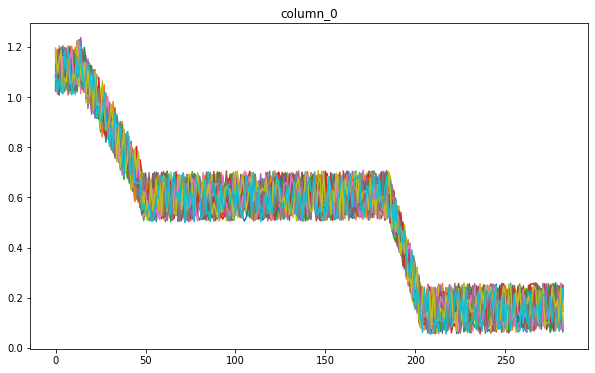

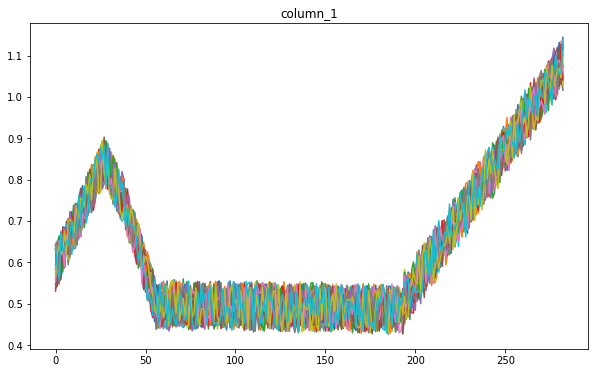

In [121]:
for sensor_name in abnormal_sample_list[0].columns:
    if sensor_name in [time_col, class_col] + key_cols:
        continue
    plt.figure(figsize=(10,6))
    plt.title(sensor_name)
    for sample in abnormal_sample_list:
        sample[sensor_name].reset_index(drop=True).plot()

In [99]:
result_df

,time,lotid,recipe,wafer_id,leak,column_0,column_1
0,2023-07-16 18:51:42,sample_0_0,sample_0_1,sample_0_2,0,0.925859,0.893388
1,2023-07-16 18:51:43,sample_0_0,sample_0_1,sample_0_2,0,0.916720,0.893315
2,2023-07-16 18:51:44,sample_0_0,sample_0_1,sample_0_2,0,0.924510,0.893493
3,2023-07-16 18:51:45,sample_0_0,sample_0_1,sample_0_2,0,0.924169,0.893116
4,2023-07-16 18:51:46,sample_0_0,sample_0_1,sample_0_2,0,0.927007,0.893826
...,...,...,...,...,...,...,...
28295,2023-07-01 18:47:01,sample_99_0,sample_99_1,sample_99_2,0,0.387638,0.931901
28296,2023-07-01 18:47:02,sample_99_0,sample_99_1,sample_99_2,0,0.387595,0.931735
28297,2023-07-01 18:47:03,sample_99_0,sample_99_1,sample_99_2,0,0.391113,0.931608
28298,2023-07-01 18:47:04,sample_99_0,sample_99_1,sample_99_2,0,0.396945,0.929760
